# **Microsoft Stock Price History**

In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import time
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-07-23 22:14:39.108805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753308879.357203      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753308879.431143      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/microsoft-stock-price-history/Microsoft_stock_data.csv


In [24]:
url='/kaggle/input/microsoft-stock-price-history/Microsoft_stock_data.csv'
df=pd.read_csv(url,sep=',')
print(df.shape)

(9911, 6)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9911 non-null   object 
 1   Close   9911 non-null   float64
 2   High    9911 non-null   float64
 3   Low     9911 non-null   float64
 4   Open    9911 non-null   float64
 5   Volume  9911 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 464.7+ KB


In [25]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['year']=df['Date'].dt.year
df['month']=df['Date'].dt.month
df['day'] = df['Date'].dt.day
iso = df['Date'].dt.isocalendar()
df['iso_week'] = iso.week
df['iso_day'] = iso.day

## **EDA**

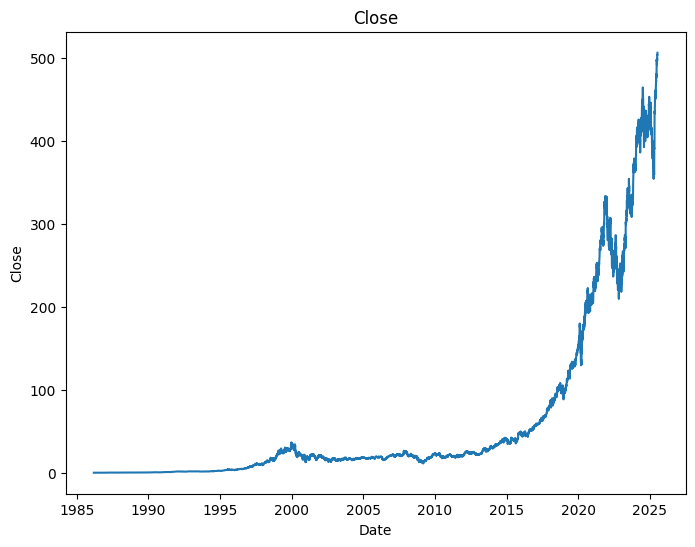

In [7]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='Date',y='Close')
plt.title('Close')
plt.show()

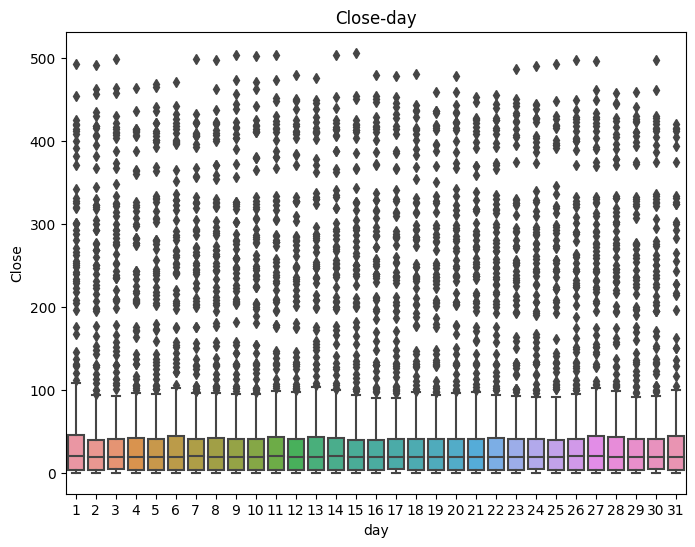

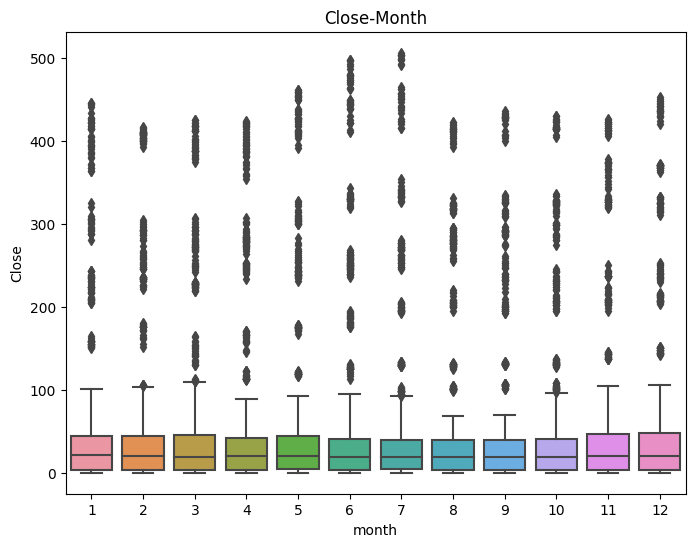

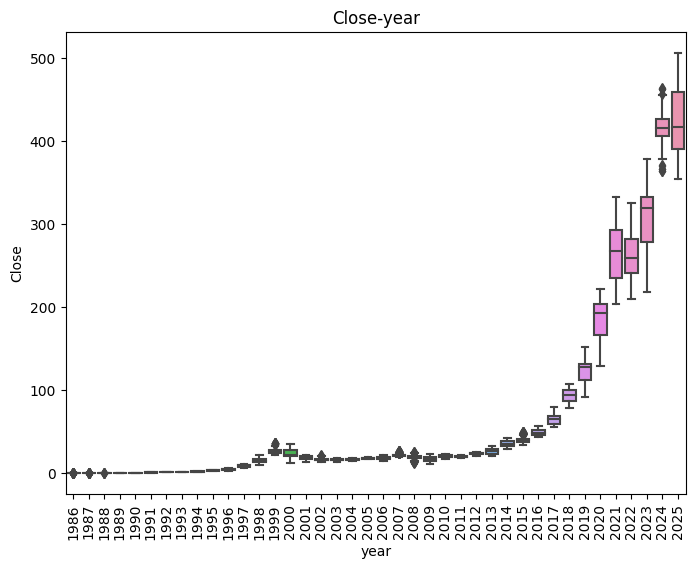

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df,y='Close',x='day')
plt.title('Close-day')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(data=df,y='Close',x='month')
plt.title('Close-Month')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(data=df,y='Close',x='year')
plt.title('Close-year')
plt.xticks(rotation='vertical')
plt.show()

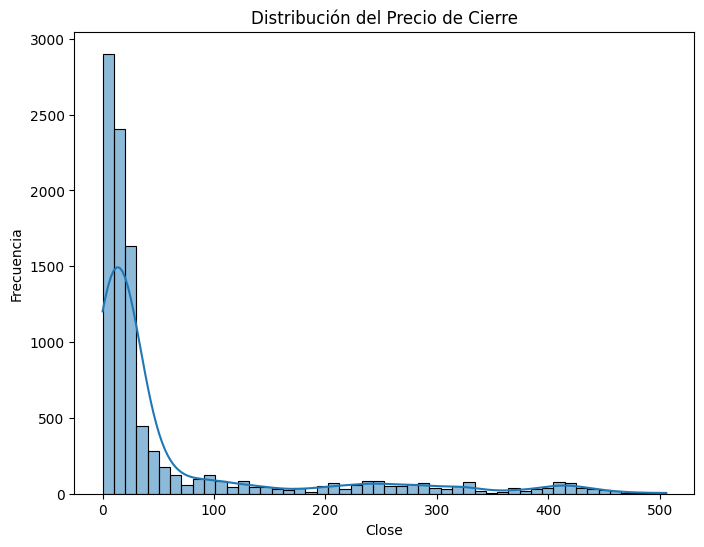

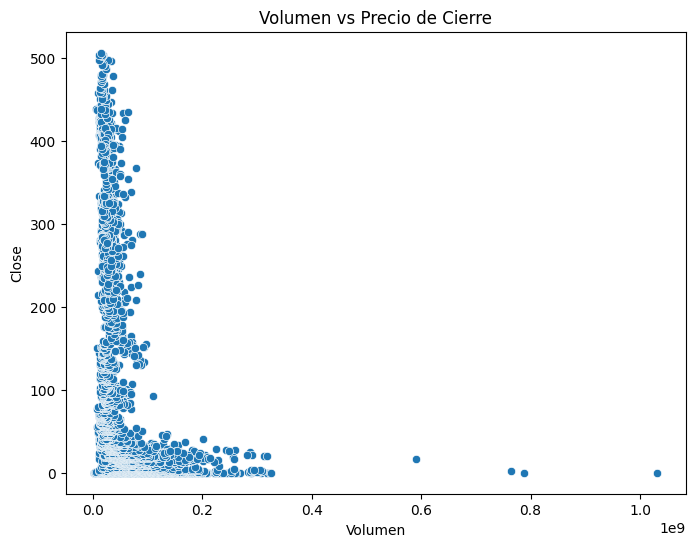

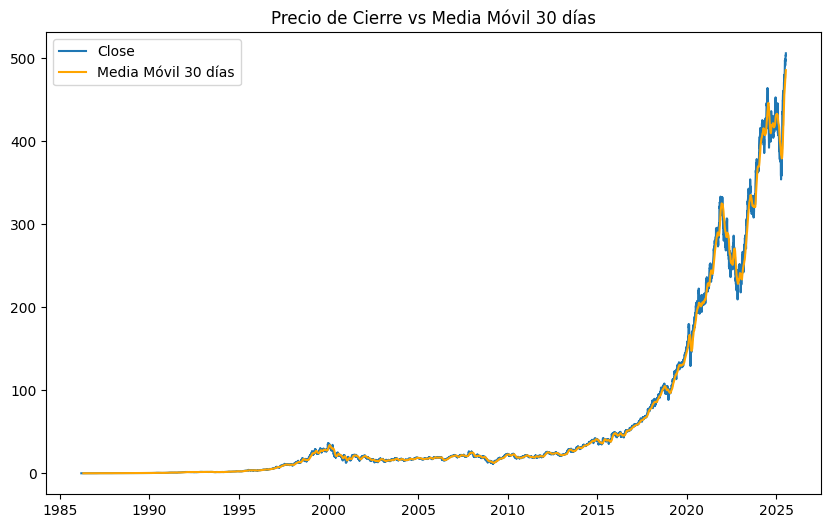

In [9]:
plt.figure(figsize=(8,6))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Close')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Volume', y='Close')
plt.title('Volumen vs Precio de Cierre')
plt.xlabel('Volumen')
plt.ylabel('Close')
plt.show()

df['MA_30'] = df['Close'].rolling(window=30).mean()
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_30'], label='Media Móvil 30 días', color='orange')
plt.title('Precio de Cierre vs Media Móvil 30 días')
plt.legend()
plt.show()



In [10]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])])
fig.update_layout(title='Gráfico de Velas Japonesas', xaxis_title='Fecha', yaxis_title='Precio')
fig.show()

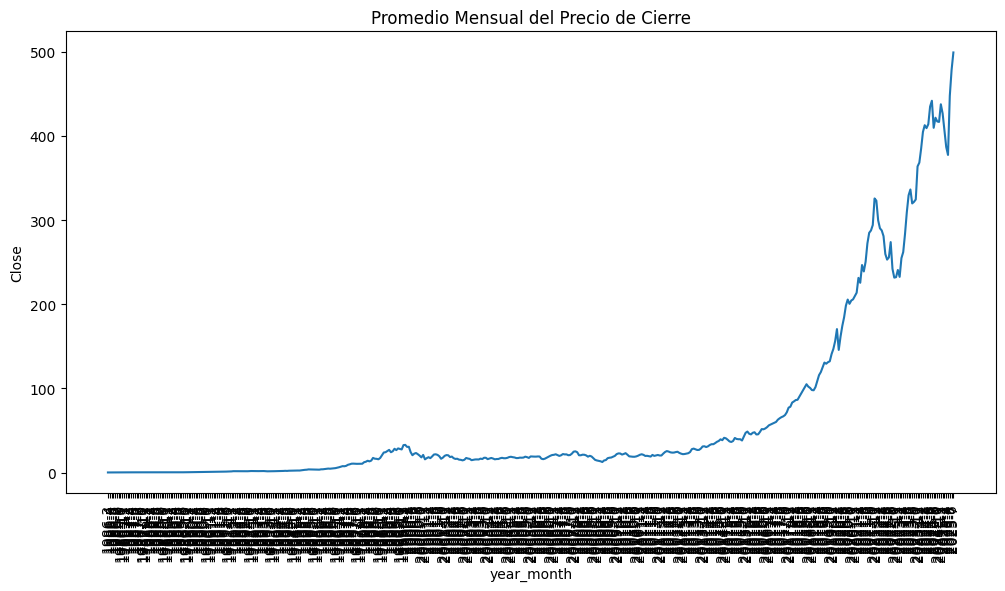

In [11]:

# Promedio mensual
monthly_avg = df.groupby(['year', 'month'])['Close'].mean().reset_index()
monthly_avg['year_month'] = monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_avg, x='year_month', y='Close')
plt.xticks(rotation=90)
plt.title('Promedio Mensual del Precio de Cierre')
plt.show()

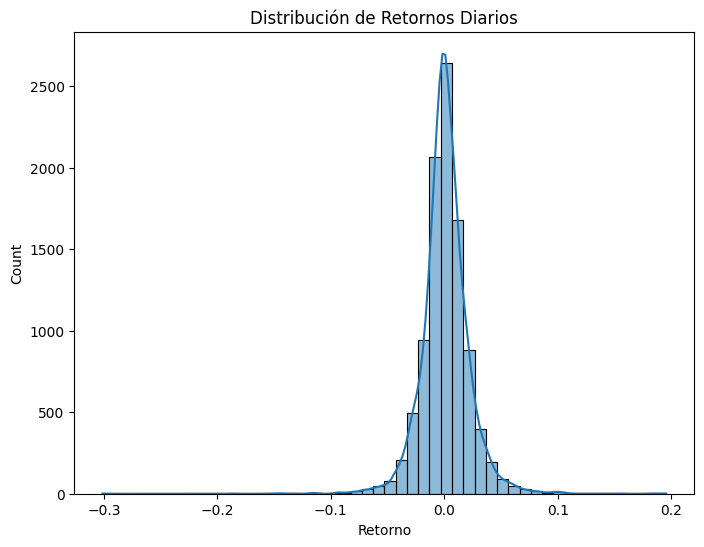

In [12]:
df['Returns'] = df['Close'].pct_change()

plt.figure(figsize=(8,6))
sns.histplot(df['Returns'].dropna(), bins=50, kde=True)
plt.title('Distribución de Retornos Diarios')
plt.xlabel('Retorno')
plt.show()


In [13]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'year', 'month',
       'day', 'iso_week', 'iso_day', 'MA_30', 'Returns'],
      dtype='object')

In [26]:
# Ordenar por fecha
df = df.sort_values('Date')

# Establecer 'Date' como índice
df = df.set_index('Date')

freq = pd.infer_freq(df.index)
print("Frecuencia inferida:", freq)

if freq == 'B':
    print("✅ La frecuencia es de días hábiles (lunes a viernes).")
else:
    print("⚠️ La frecuencia NO es estrictamente de lunes a viernes (frecuencia inferida: {})".format(freq))

Frecuencia inferida: None
⚠️ La frecuencia NO es estrictamente de lunes a viernes (frecuencia inferida: None)


In [27]:
# Crear un rango completo de días hábiles (lunes a viernes)
business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

# Buscar días hábiles faltantes
missing_bdays = business_days.difference(df.index)

print(f"Cantidad de días hábiles faltantes: {len(missing_bdays)}")
if len(missing_bdays) == 0:
    print("✅ Tu serie contiene todos los días hábiles.")
else:
    print("❌ Faltan algunos días hábiles en la serie.")
    print("Ejemplos de fechas faltantes:", missing_bdays[:5])


Cantidad de días hábiles faltantes: 353
❌ Faltan algunos días hábiles en la serie.
Ejemplos de fechas faltantes: DatetimeIndex(['1986-03-28', '1986-05-26', '1986-07-04', '1986-09-01',
               '1986-11-27'],
              dtype='datetime64[ns]', freq=None)


In [35]:
# Crear un rango completo de días hábiles (lunes a viernes)
business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

# Reindexar el DataFrame al rango de días hábiles
df_bday = df.reindex(business_days)

# Ver cuántos valores quedaron como NaN
print("Valores nulos por columna después de reindexar:")
print(df_bday.isna().sum())

# Rellenar los valores nulos con el último valor válido (forward fill)
df_bday.fillna(method='ffill', inplace=True)

# Verificar si ya no hay nulos
print("\n¿Aún quedan valores nulos?")
print(df_bday.isna().sum())

# Renombrar el índice si deseas
df_bday.index.name = 'Date'

Valores nulos por columna después de reindexar:
Close       353
High        353
Low         353
Open        353
Volume      353
year        353
month       353
day         353
iso_week    353
iso_day     353
dtype: int64

¿Aún quedan valores nulos?
Close       0
High        0
Low         0
Open        0
Volume      0
year        0
month       0
day         0
iso_week    0
iso_day     0
dtype: int64


In [36]:
freq = pd.infer_freq(df_bday.index)
print("Frecuencia inferida:", freq)

if freq == 'B':
    print("✅ La frecuencia es de días hábiles (lunes a viernes).")
else:
    print("⚠️ La frecuencia NO es estrictamente de lunes a viernes (frecuencia inferida: {})".format(freq))

Frecuencia inferida: B
✅ La frecuencia es de días hábiles (lunes a viernes).


In [38]:
df_bday=df_bday[['Close']]

# Tomar la serie de cierre
serie = df_bday['Close'].dropna()

# Aplicar prueba ADF
resultado = adfuller(serie)

print('ADF Statistic:', resultado[0])
print('p-value:', resultado[1])
for key, value in resultado[4].items():
    print('Valor crítico {}: {:.3f}'.format(key, value))

# Interpretación
if resultado[1] < 0.05:
    print("✅ La serie es estacionaria (rechazamos H0)")
else:
    print("❌ La serie NO es estacionaria (no rechazamos H0)")

ADF Statistic: 4.618379583250678
p-value: 1.0
Valor crítico 1%: -3.431
Valor crítico 5%: -2.862
Valor crítico 10%: -2.567
❌ La serie NO es estacionaria (no rechazamos H0)


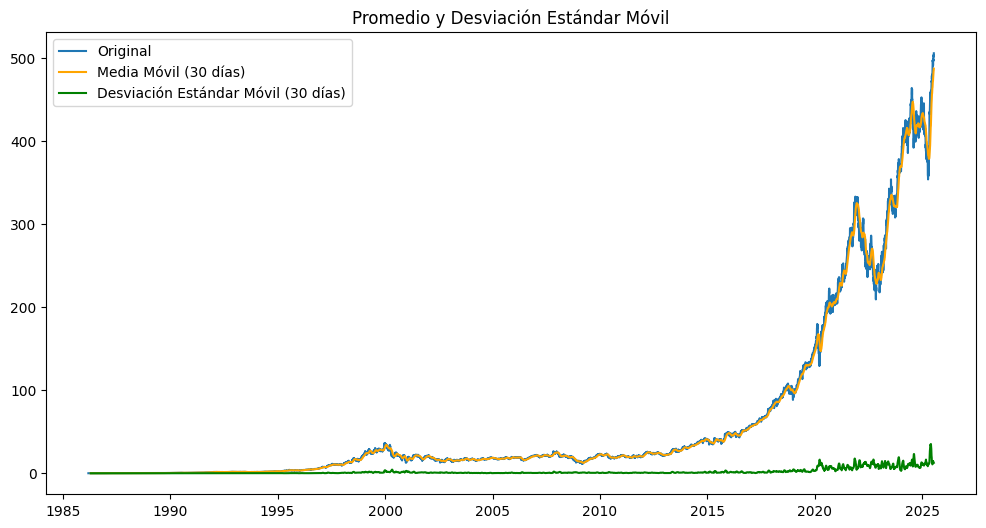

In [39]:
rolmean = serie.rolling(window=30).mean()
rolstd = serie.rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(serie, label='Original')
plt.plot(rolmean, label='Media Móvil (30 días)', color='orange')
plt.plot(rolstd, label='Desviación Estándar Móvil (30 días)', color='green')
plt.legend(loc='best')
plt.title('Promedio y Desviación Estándar Móvil')
plt.show()

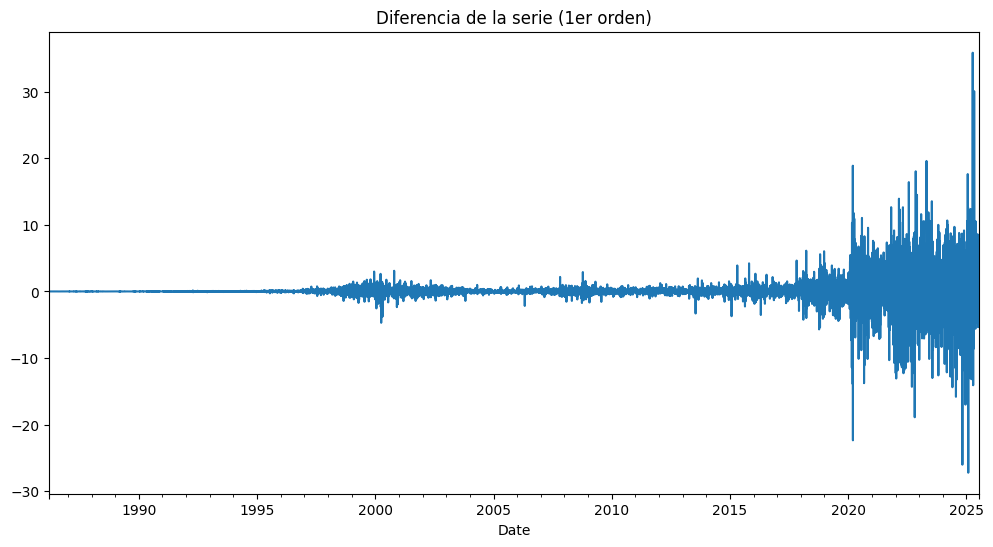

ADF Statistic (Differenced): -16.312491040599784
p-value: 3.185857561375885e-29
✅ La serie diferenciada es estacionaria


In [40]:
df_bday['Close_diff'] = df_bday['Close'] - df_bday['Close'].shift(1)
df_bday['Close_diff'].dropna().plot(figsize=(12,6), title='Diferencia de la serie (1er orden)')
plt.show()

# Prueba ADF de nuevo
resultado2 = adfuller(df_bday['Close_diff'].dropna())
print('ADF Statistic (Differenced):', resultado2[0])
print('p-value:', resultado2[1])
if resultado2[1] < 0.05:
    print("✅ La serie diferenciada es estacionaria")
else:
    print("❌ Aún no es estacionaria")

## **MODELO ARIMA**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10264
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -21311.807
Date:                Wed, 23 Jul 2025   AIC                          42629.614
Time:                        21:35:04   BIC                          42651.323
Sample:                    03-13-1986   HQIC                         42636.953
                         - 07-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2882      0.041      7.065      0.000       0.208       0.368
ma.L1         -0.3606      0.040     -8.989      0.000      -0.439      -0.282
sigma2         3.7257      0.011    331.030      0.0

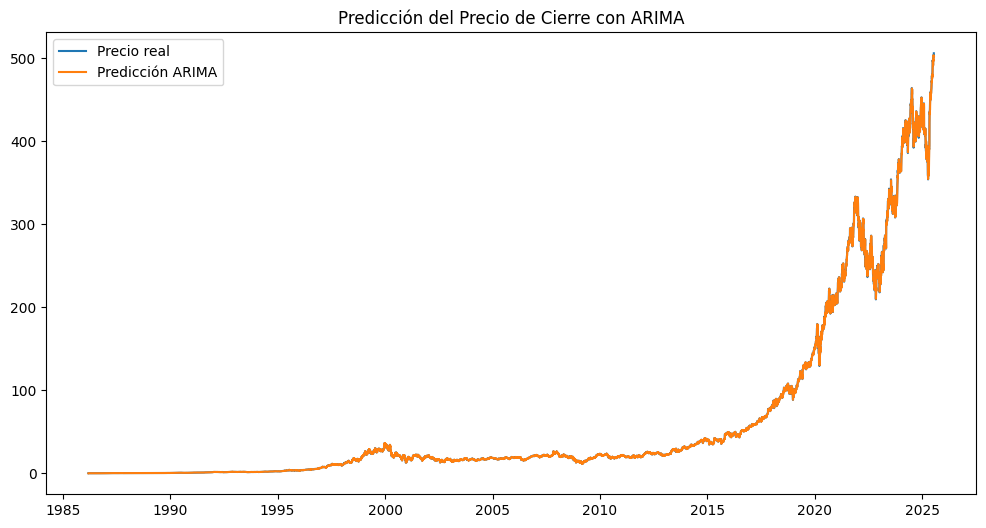

In [42]:
# Crear y ajustar el modelo ARIMA
# p=valor autoregresivo, d=1 (diferencia), q=valor de media móvil
modelo = ARIMA(df_bday['Close'], order=(1, 1, 1))
resultado = modelo.fit()

# Resumen del modelo
print(resultado.summary())

# Pronóstico
pred = resultado.predict(start=0, end=len(df_bday) + 30, typ='levels')  # typ='levels' para revertir la diferencia
df_bday['Predicción'] = pred[:len(df_bday)]

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df_bday['Close'], label='Precio real')
plt.plot(df_bday['Predicción'], label='Predicción ARIMA')
plt.legend()
plt.title('Predicción del Precio de Cierre con ARIMA')
plt.show()


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Supongamos que tienes estos:
# y_true: valores reales
# y_pred: predicciones del modelo

# Por ejemplo, reservamos los últimos 30 días para validación:
n_test = 30
y_true = df_bday['Close'][-n_test:]  # valores reales
y_pred = resultado.predict(start=len(df_bday)-n_test, end=len(df_bday)-1, typ='levels')  # predicción del modelo

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mostrar resultados
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE: 13.4100
RMSE: 3.6620
MAE: 2.9129
MAPE: 0.60%


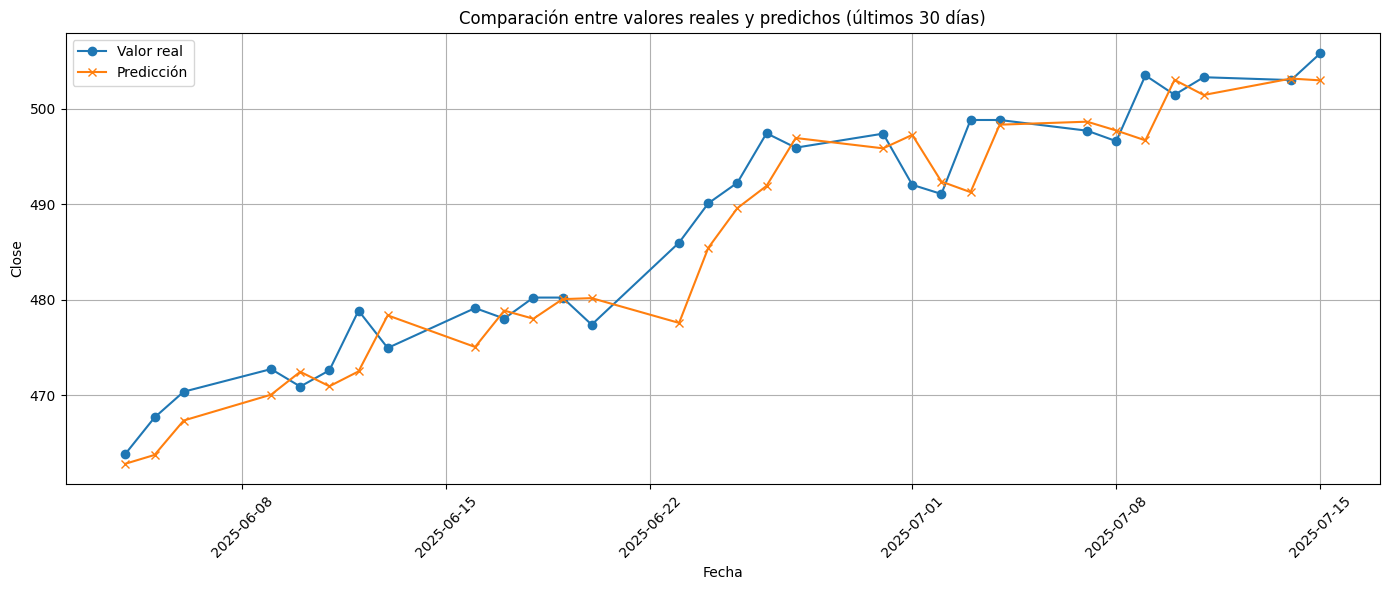

In [49]:
# Gráfico comparativo
plt.figure(figsize=(14, 6))
plt.plot(y_true.index, y_true, label='Valor real', marker='o')
plt.plot(y_pred.index, y_pred, label='Predicción', marker='x')
plt.title('Comparación entre valores reales y predichos (últimos 30 días)')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Modelo LSTM

Epoch 1/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 70s 170ms/step - loss: 0.6804 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 2/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - loss: 0.0106 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 3/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - loss: 0.0036 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 4/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - loss: 0.0028 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 5/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - loss: 0.0026 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 6/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - loss: 0.0023 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 7/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - loss: 0.0021 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 8/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - loss: 0.0018 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 9/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - loss: 0.0017 - val_loss: 0.018

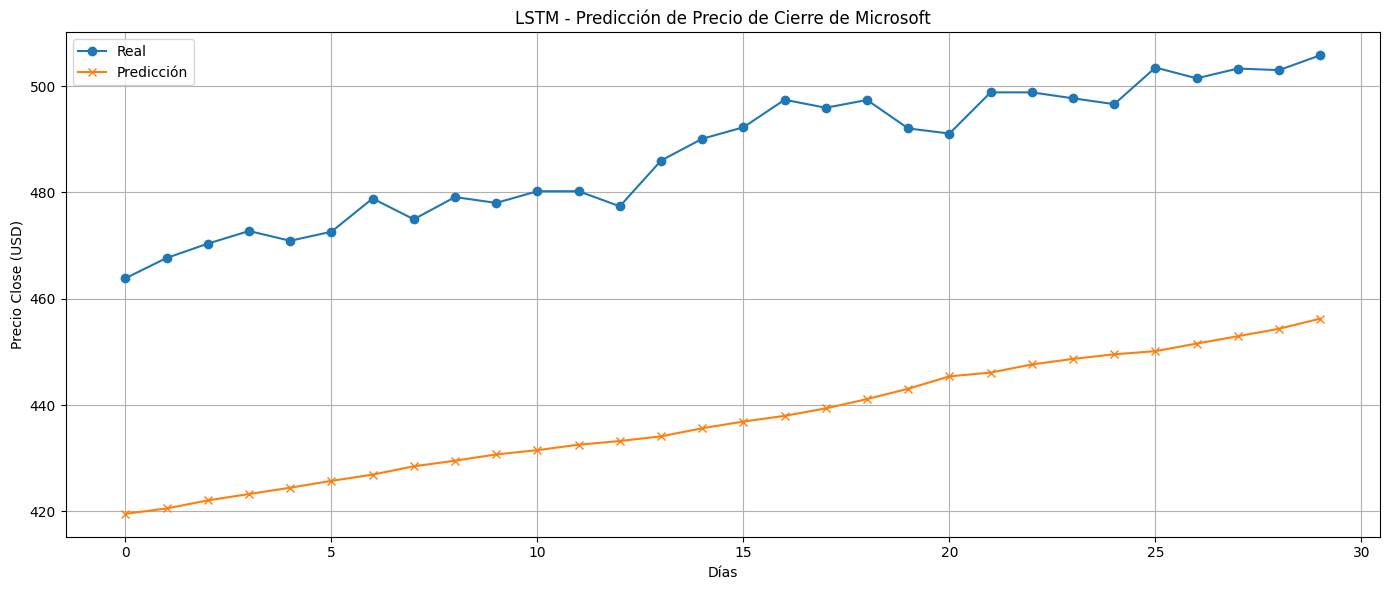

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Escalar datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_bday[['Close']])

# 3. Preparar secuencias de entrenamiento
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# 4. Redimensionar X para LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 5. Separar entrenamiento y prueba (últimos 30 días para test)
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# 6. Construir modelo LSTM
model = Sequential()

# Primera capa LSTM bidireccional (captura mejor las dependencias)
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LayerNormalization())

# Segunda capa LSTM
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LayerNormalization())

# Tercera capa LSTM (sin return_sequences)
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(LayerNormalization())

# Capa de salida
model.add(Dense(1))

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


# 7. Hacer predicciones
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# 8. Calcular métricas
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# 9. Gráfico de resultados
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Real', marker='o')
plt.plot(y_pred_inv, label='Predicción', marker='x')
plt.title('LSTM - Predicción de Precio de Cierre de Microsoft')
plt.xlabel('Días')
plt.ylabel('Precio Close (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

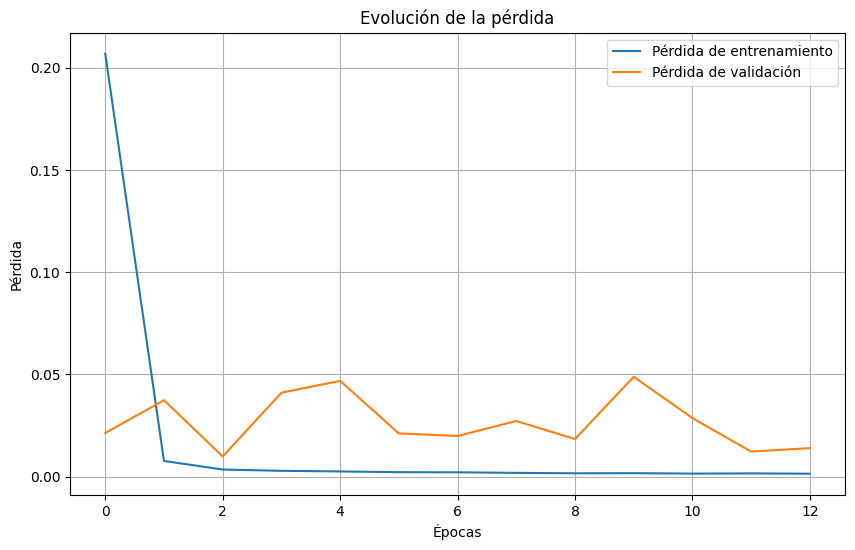

In [59]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## **Conclusión**

El mejor modelo para predecir las acciones de microsoft es el de ARIMA